# Optimización de Parámetros - DL - RNN

In [1]:
## Get current work directory to load all the custom modules
from pathlib import Path
import os
import sys
BASE_DIR = Path().absolute().resolve(strict=True).parent.parent.parent
if str(BASE_DIR) not in sys.path:
    sys.path.append(str(BASE_DIR))

In [2]:
DATA_PATH = os.path.join(BASE_DIR, 'data', 'autos')
print(DATA_PATH)

/workspace/Externos/TimeSeries/BenchMark/data/autos


In [3]:
import pandas as pd


In [4]:
import optuna
import datetime

In [5]:
from modulos.arima.gruas.general import format_timeseries, show_results_r2, arima_forecasting, total_forecasting, show_optimizer_results
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf


from modulos.LR.gruas.generals import make_lags
from modulos.DL.gruas.custom_models import ForecastinModel, cross_val_score_dl
from modulos.DL.gruas.optimizer import DLOptimizer

2021-12-02 02:25:28.659376: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-02 02:25:28.659409: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
data = pd.read_csv(os.path.join(DATA_PATH, 'producto.csv'), parse_dates=['Periodo'])
data.head()

,Periodo,idArticulo,ventas,DescProducto
0,2021-10-01,9950,74.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GAL...
1,2021-09-01,9950,25.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GAL...
2,2021-08-01,9950,28.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GAL...
3,2021-07-01,9950,15.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GAL...
4,2021-06-01,9950,13.0,REFRIGERANTE COOLANT AZUL/NATURAL TRANSP. GAL...


In [7]:
# Pivotando las tablas y llenando de ceros las ventas que no existen.
df_time = format_timeseries(data)
df_time.tail()

idArticulo,551,594,963,1208,1224,1627,3090,3745,3882,3883,...,20263,20301,20305,20310,20697,20769,21577,23900,26158,27165
Periodo,,,,,,,,,,,,,,,,,,,,,
2021-06-01,4.0,3.0,6.0,140.0,0.0,5.0,4.0,5.0,2.0,0.0,...,4.0,6.0,0.0,2.0,2.0,0.0,6.0,104.0,42.0,11.0
2021-07-01,2.0,1.0,14.0,166.0,10.0,17.0,2.0,0.0,1.0,3.0,...,8.0,9.0,4.0,6.0,1.0,3.0,15.0,40.0,17.0,42.0
2021-08-01,8.0,4.0,2.0,520.0,7.0,4.0,11.0,2.0,0.0,4.0,...,48.0,5.0,7.0,7.0,5.0,2.0,33.0,228.0,38.0,12.0
2021-09-01,3.0,10.0,4.0,280.0,2.0,9.0,11.0,8.0,1.0,1.0,...,8.0,8.0,5.0,0.0,10.0,2.0,10.0,84.0,14.0,19.0
2021-10-01,3.0,4.0,3.0,510.0,4.0,3.0,4.0,5.0,0.0,9.0,...,12.0,15.0,25.0,13.0,5.0,3.0,4.0,316.0,9.0,19.0


## Baseline DL

In [8]:
from modulos.LR.gruas.generals import split_data_train, make_timeserie

idArticulo = 594
ts = df_time[idArticulo].copy()
n_lags = 4
X,y, scaler  = make_timeserie(ts, n_lags)

data = pd.concat({'Targets': y, 'Features': X}, axis=1)

data.tail(10).style.set_properties(['Targets'], **{'background-color': 'green'}) \
                   .set_properties(['Features'], **{'background-color': 'magenta'})
    

## Deel learning - serie de tiempo - cross validation

In [9]:
_ = ForecastinModel((X.iloc[0].shape[0],1), )
forecasting = ForecastinModel((X.iloc[0].shape[0],1), n_epochs=10, summary=False, )

2021-12-02 02:25:30.138862: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2021-12-02 02:25:30.138902: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: davelinux-G551JM
2021-12-02 02:25:30.138911: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: davelinux-G551JM
2021-12-02 02:25:30.139022: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.86.0
2021-12-02 02:25:30.139062: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.82.0
2021-12-02 02:25:30.139072: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.82.0 does not match DSO version 470.86.0 -- cannot find working devices in this configuration
2021-12-02 02:25:30.139632: I tensorflow/core/platform/cpu_feature_guard.cc:151]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 1)]       0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 1)            12          ['input_1[0][0]']                
                                                                                                  
 flatten_1 (Flatten)            (None, 4)            0           ['input_1[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 1)            0           ['lstm[0][0]']                   
                                                                                              

In [10]:
mse, r2_ = cross_val_score_dl(forecasting, X, y, test_size=.1,)
print(f"Cross validation results MSE: {mse} ")
print(f"Cross validation results R2: {r2_} ")

Cross validation results MSE: 4.431655948511543 
Cross validation results R2: -0.940818293992121 


## Training a single model without optimization (concepto)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)
forecasting = ForecastinModel((X.iloc[0].shape[0],1),summary=False)
forecasting.train_model(X_train, y_train, X_test,  y_test, epochs=200, batch_size=32, workers=4, verbose= 0, callback=True, logs=True, checkpoint=True)

y_fit = pd.DataFrame(forecasting.model.predict(X), index=X.index, columns=y.columns)
#y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

/home/dave-linux/.local/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


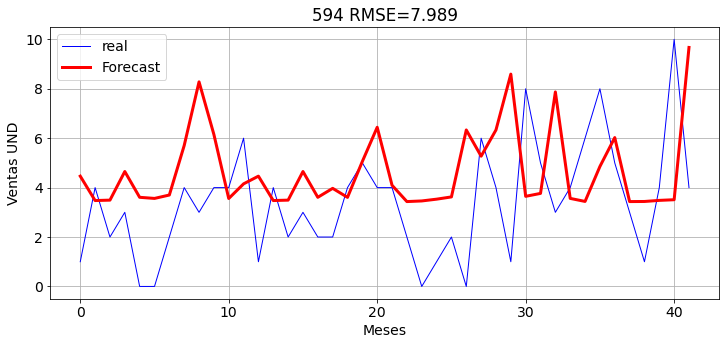

In [12]:
mse_scl = scaler.inverse_transform([[np.sqrt(mse)]])[0][0]
show_results_r2(scaler.inverse_transform(y), scaler.inverse_transform(y_fit),idArticulo, score=mse_scl, score_name='RMSE' )


# Optimizar todos los Productos        

In [13]:
optimizer = DLOptimizer(df_time, iterations=120, data_path= DATA_PATH , model='DL', subpath = None)
optimizer.run( chunk_size=4)

2021-12-02 03:48:39.371104: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-02 06:01:55.972777: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-02 08:16:16.363105: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-02 09:39:39.195330: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-02 09:49:01.588268: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-02 15:39:12.856665: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2021-12-02 18:03:15.471086: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


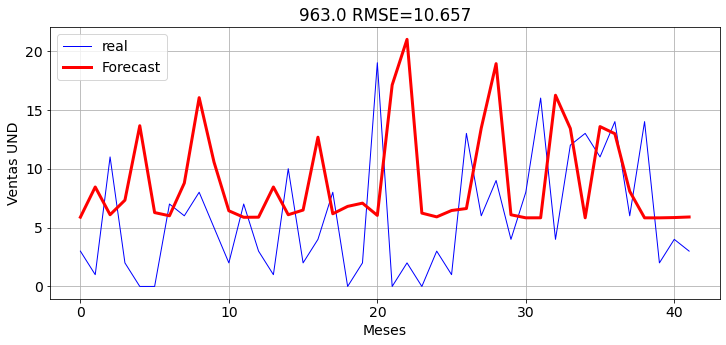

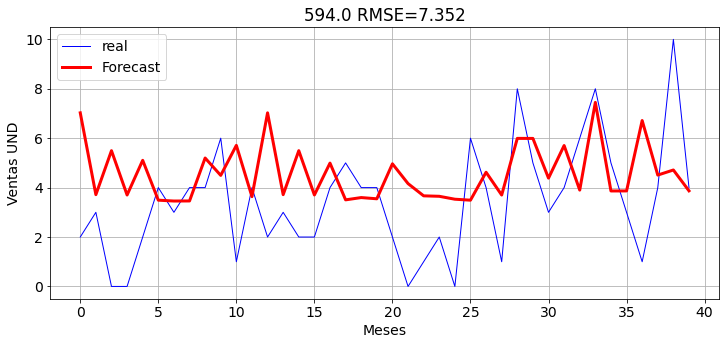

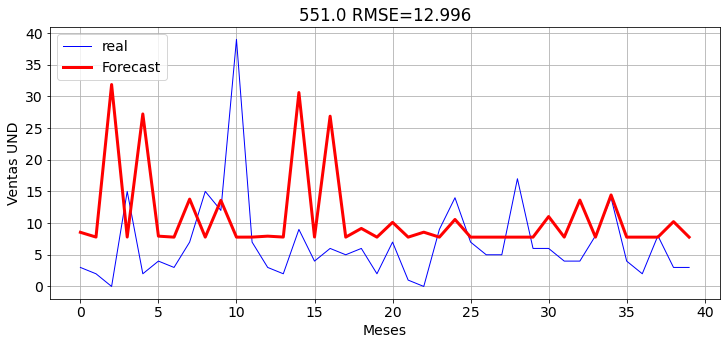

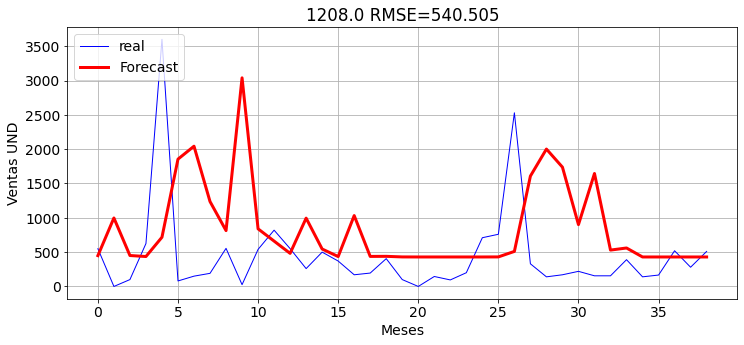

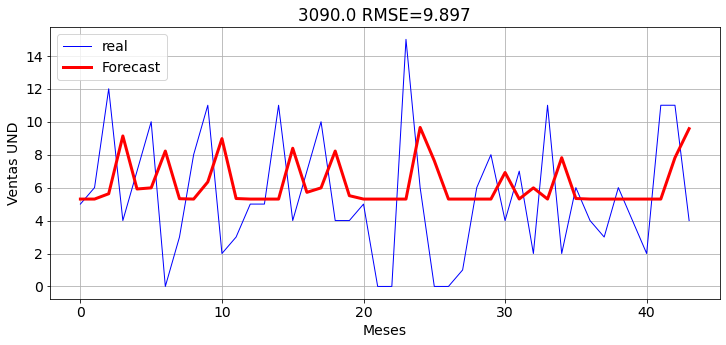

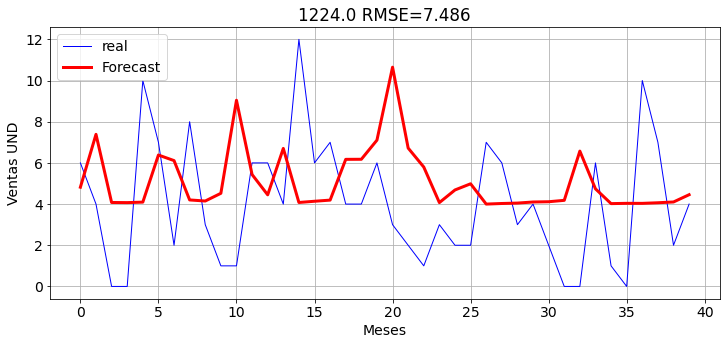

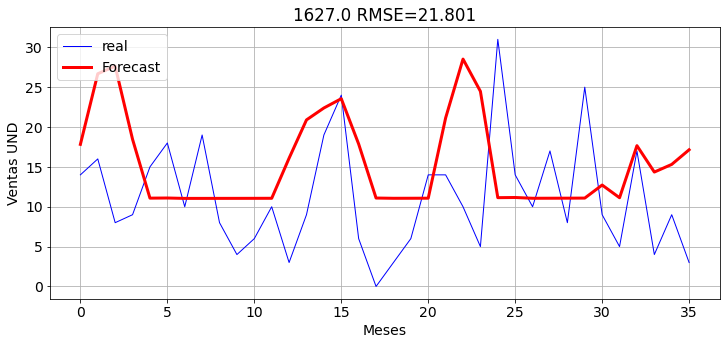

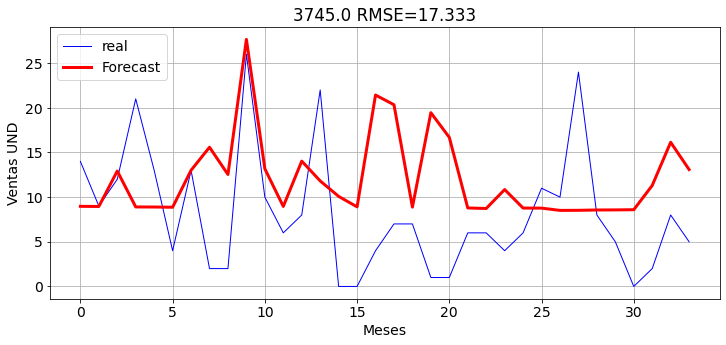

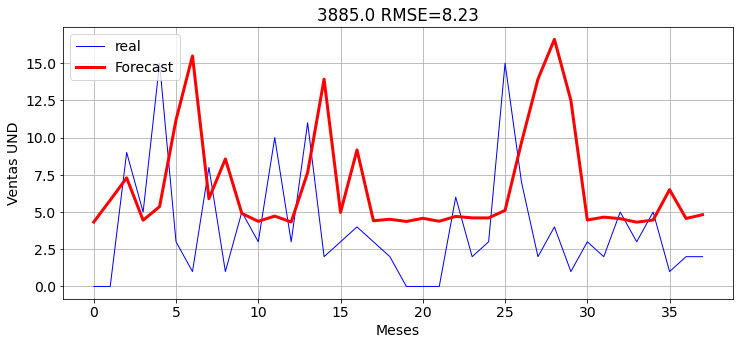

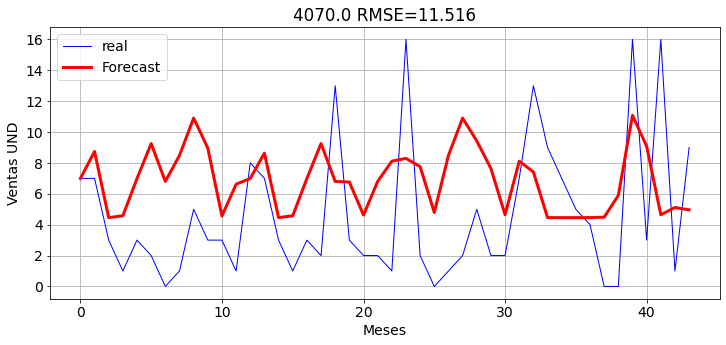

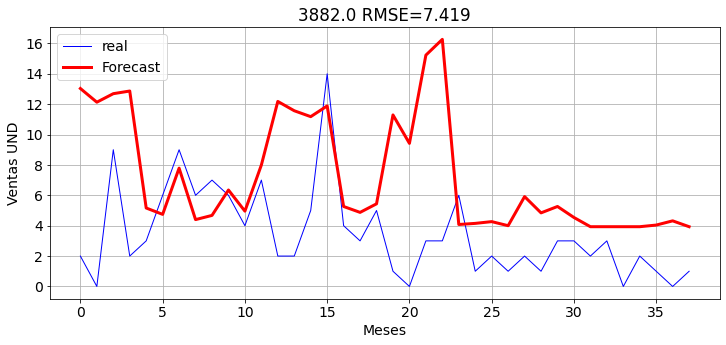

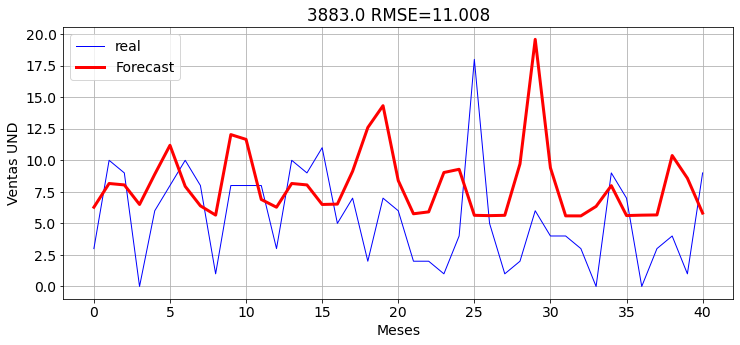

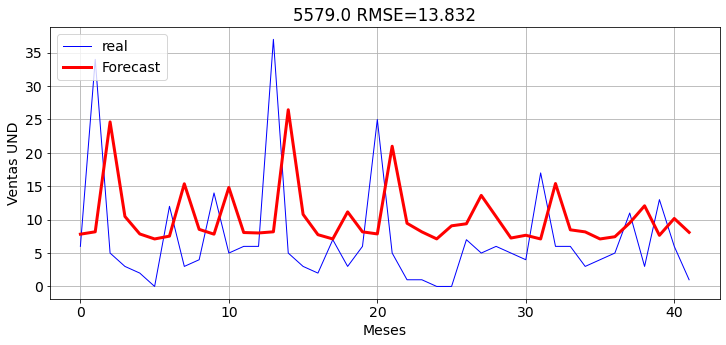

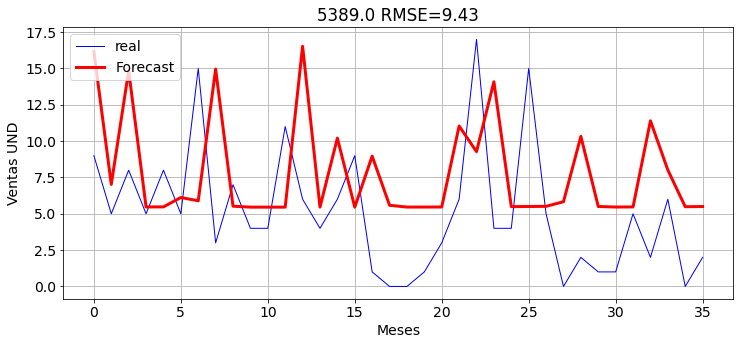

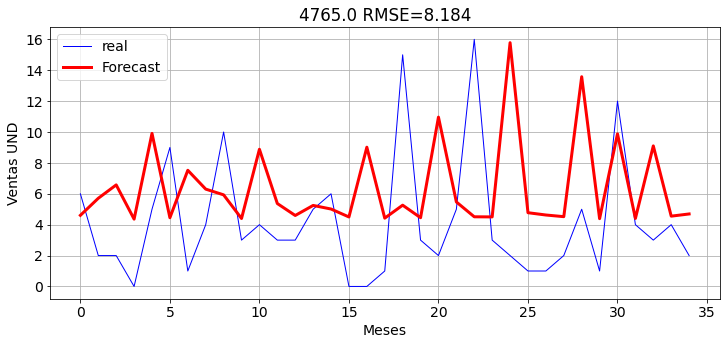

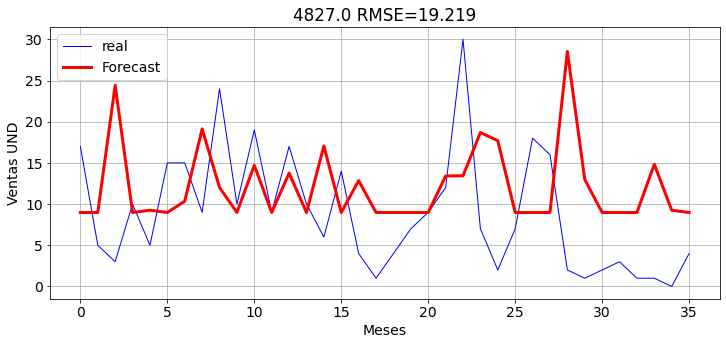

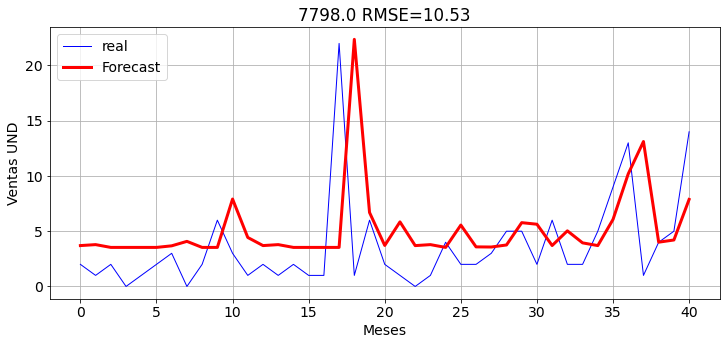

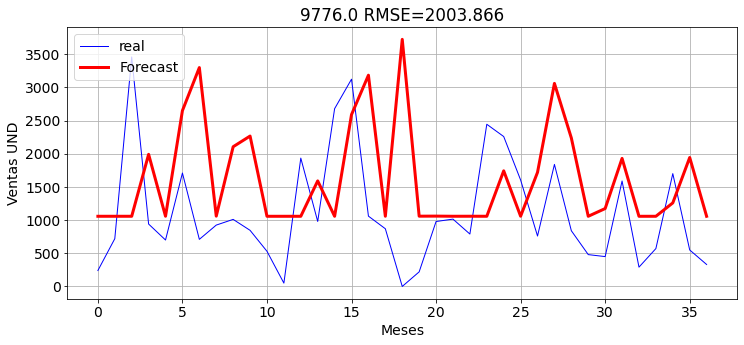

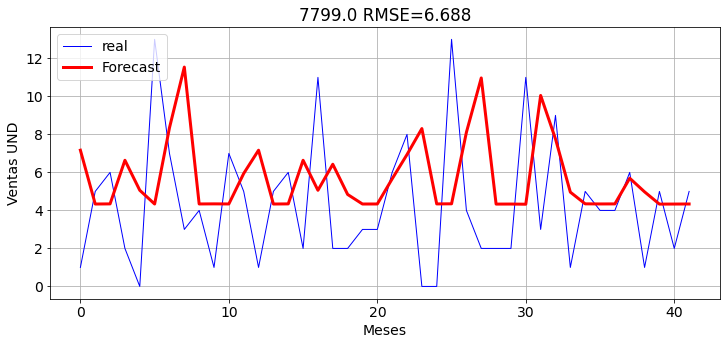

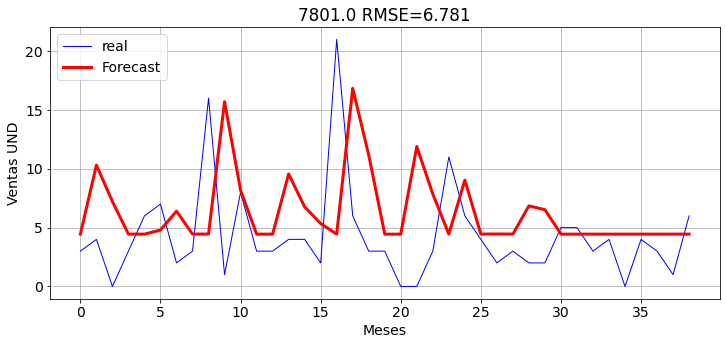

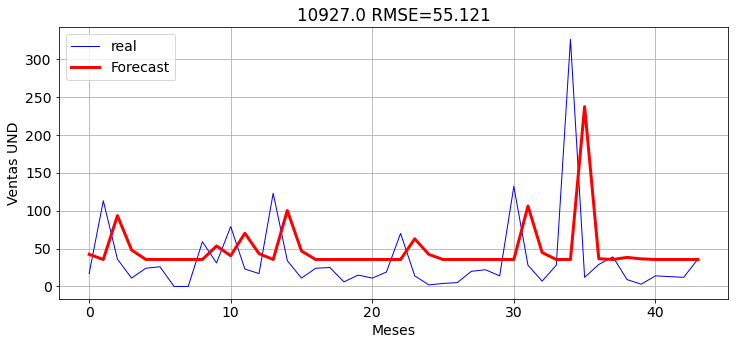

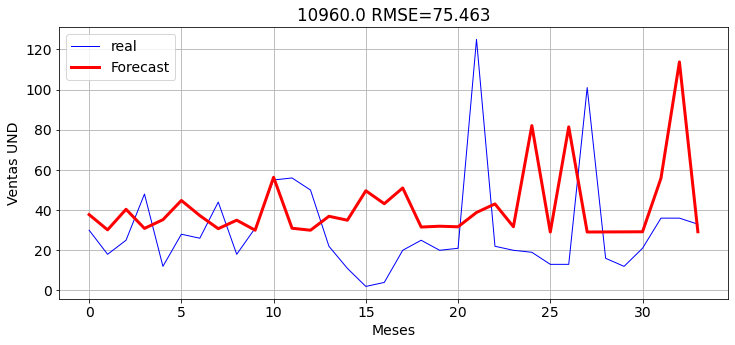

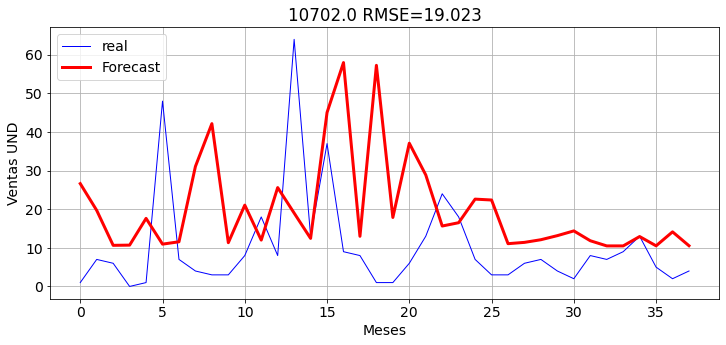

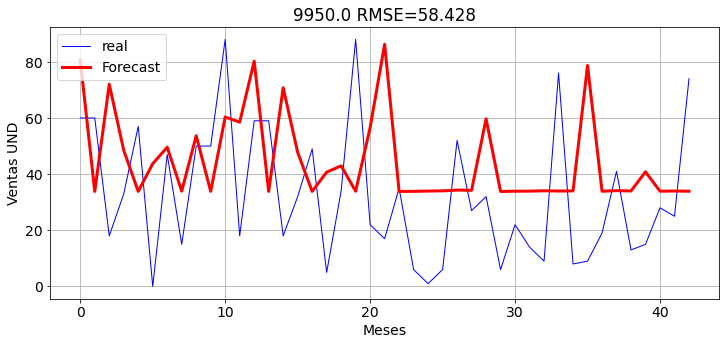

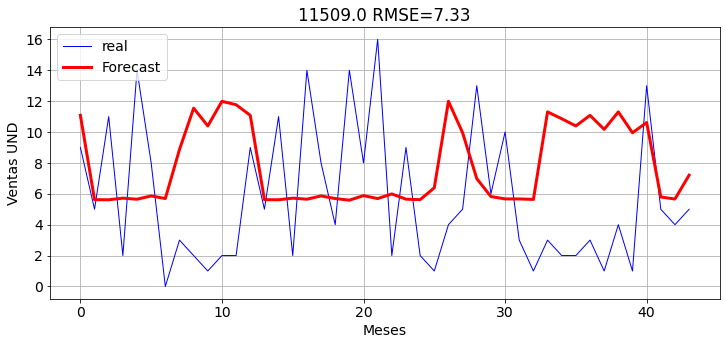

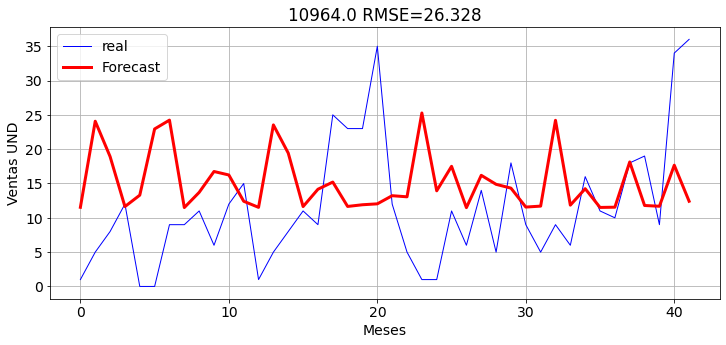

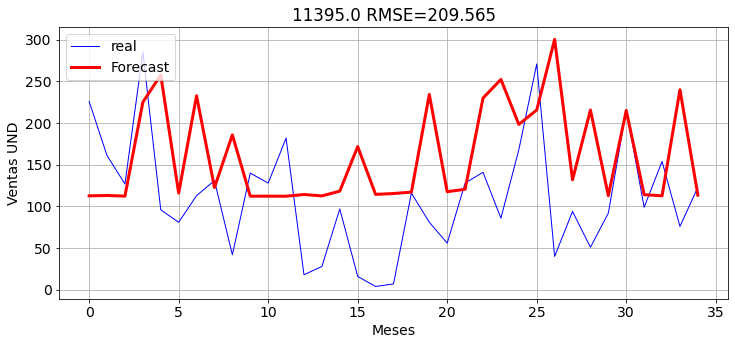

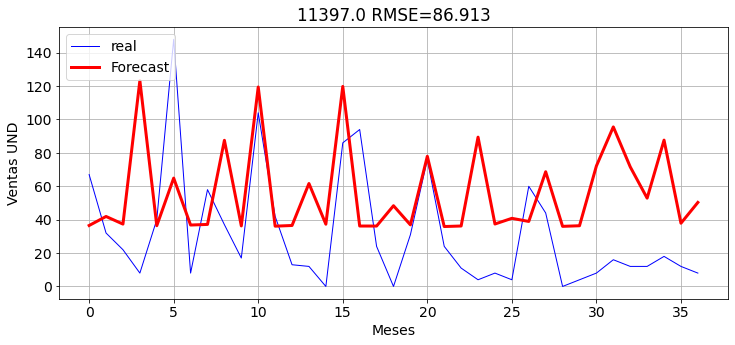

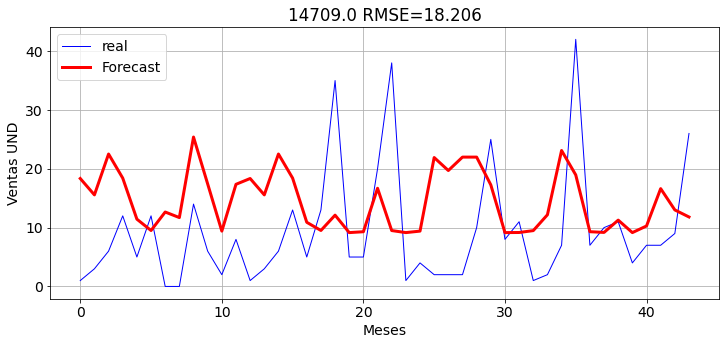

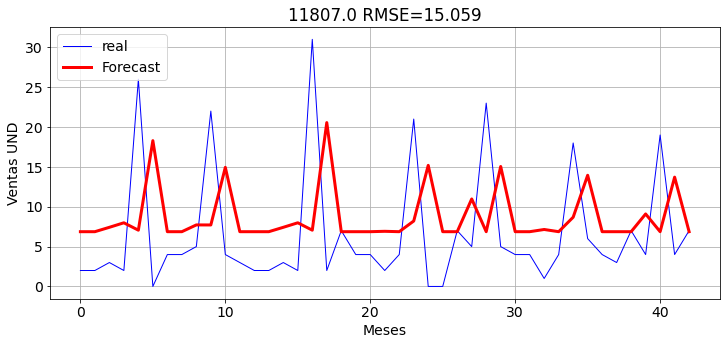

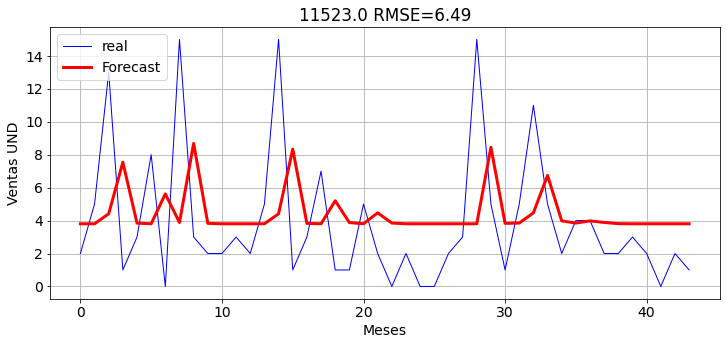

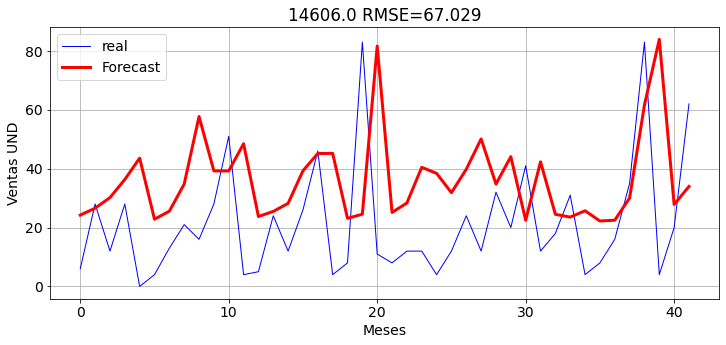

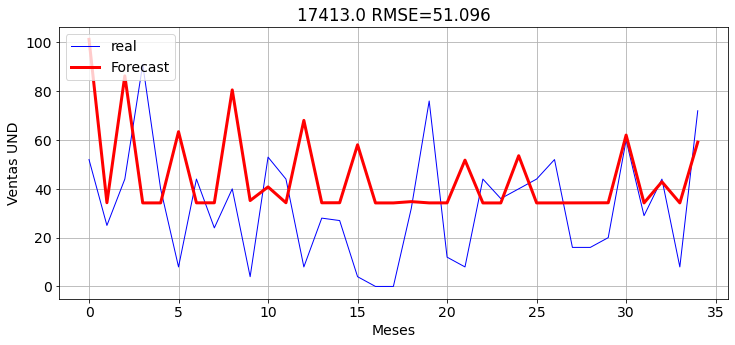

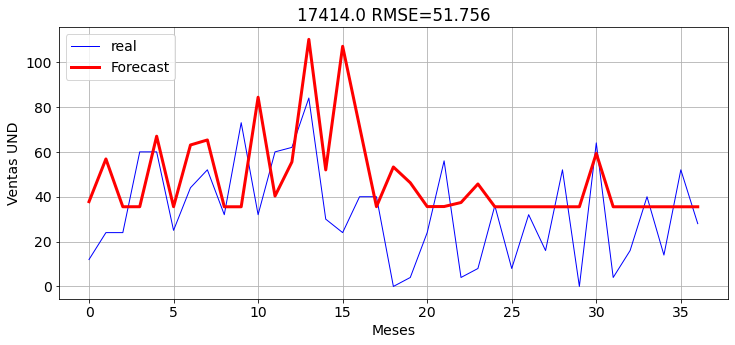

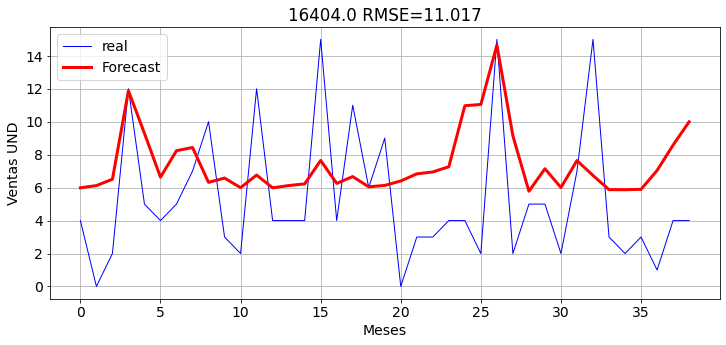

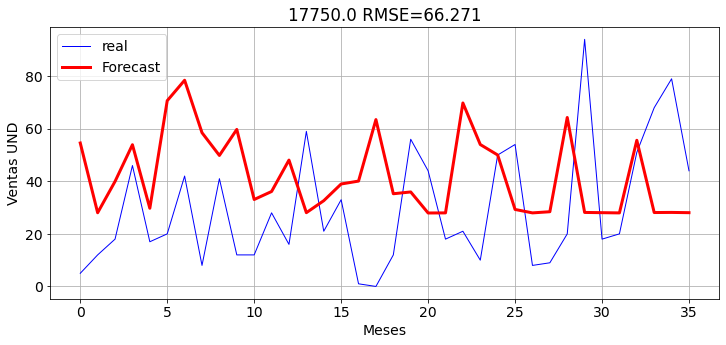

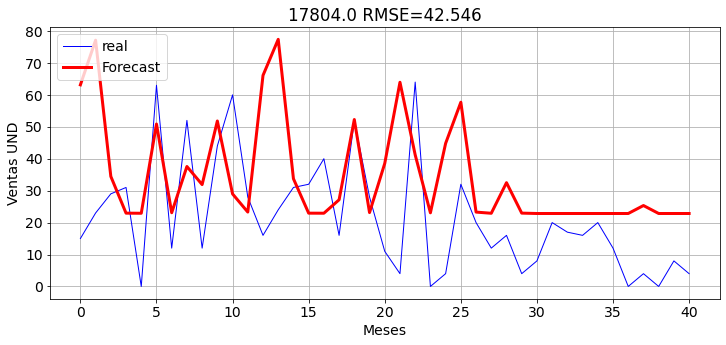

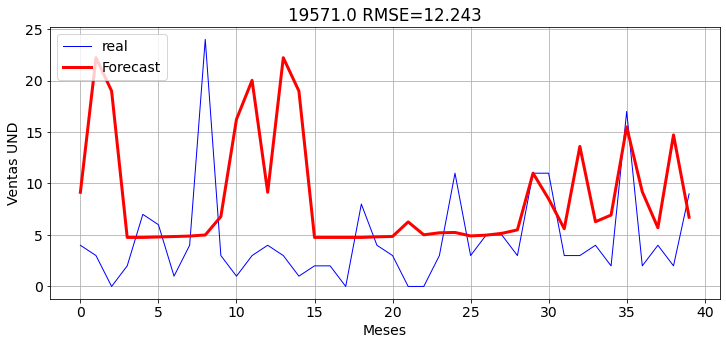

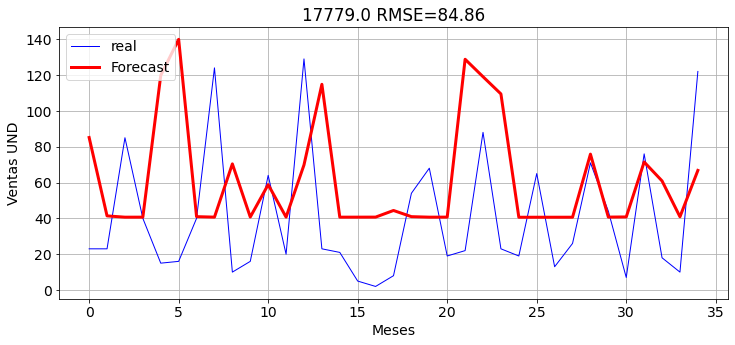

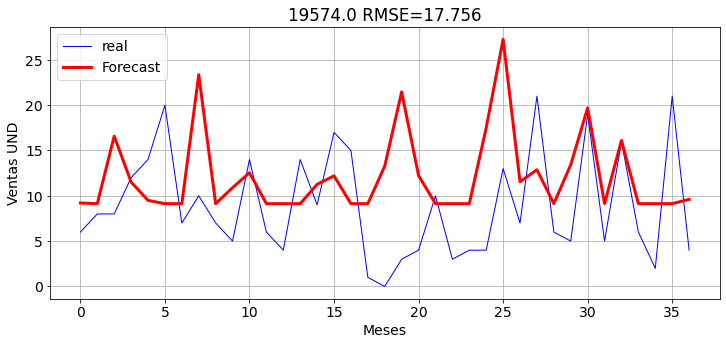

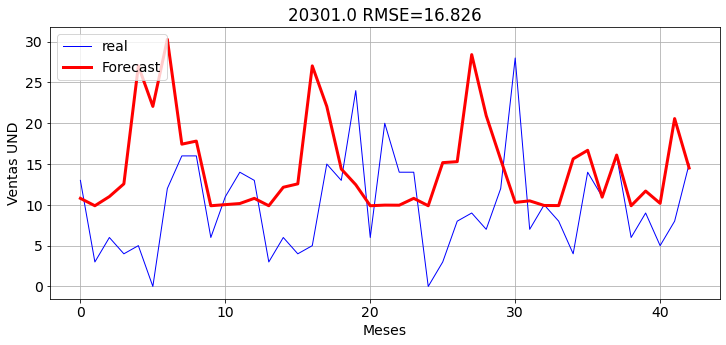

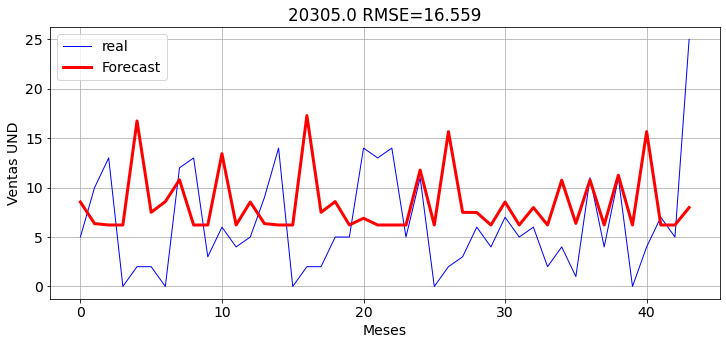

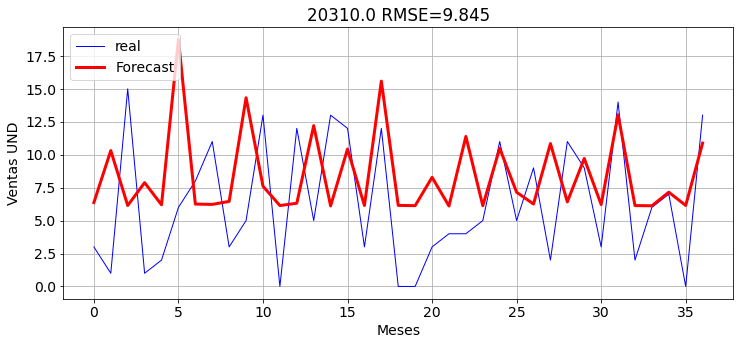

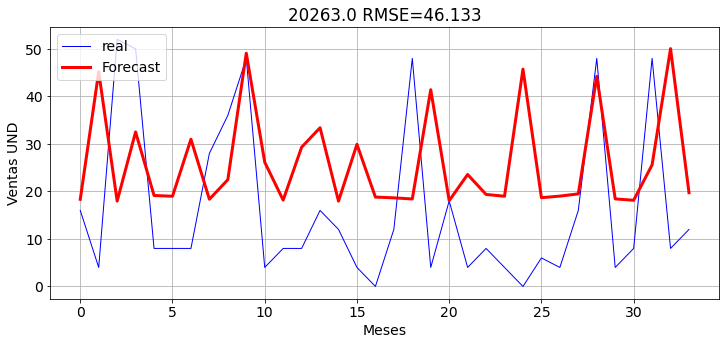

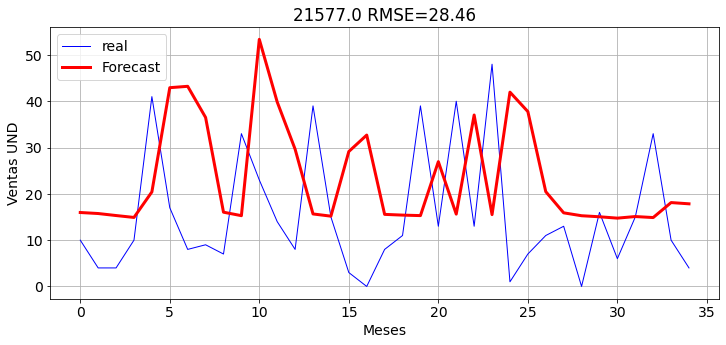

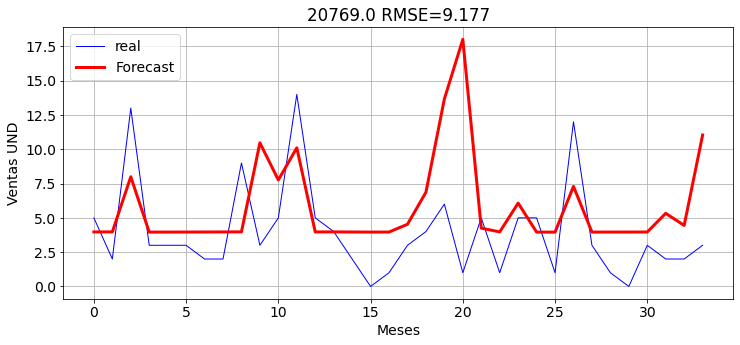

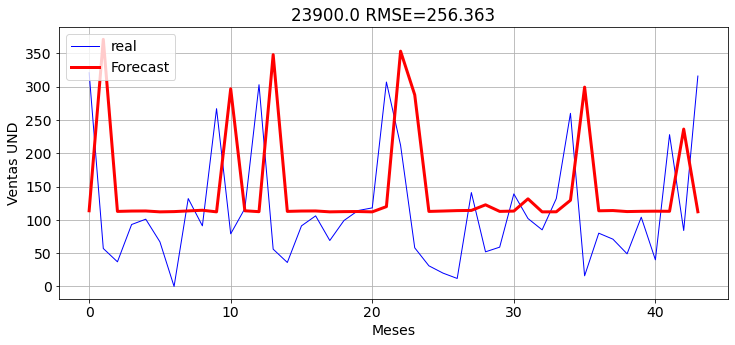

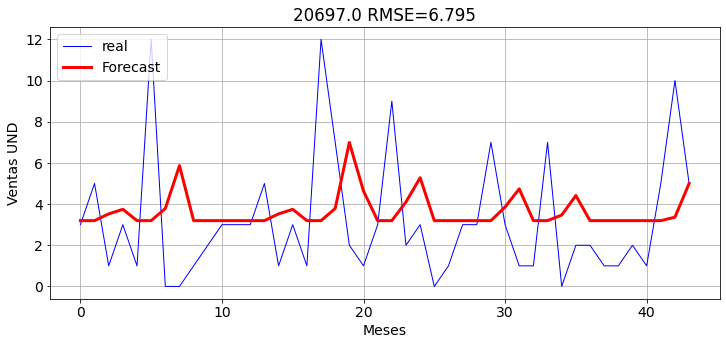

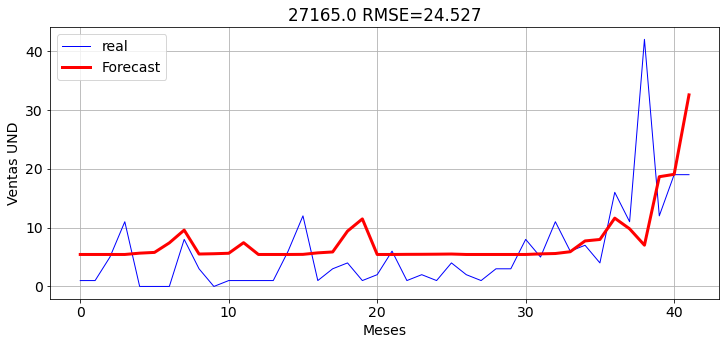

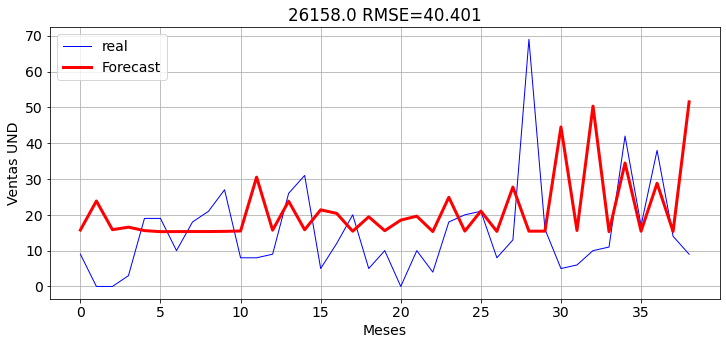

In [14]:
optimizer.print_results()

# Optimizer -  Evolution on time

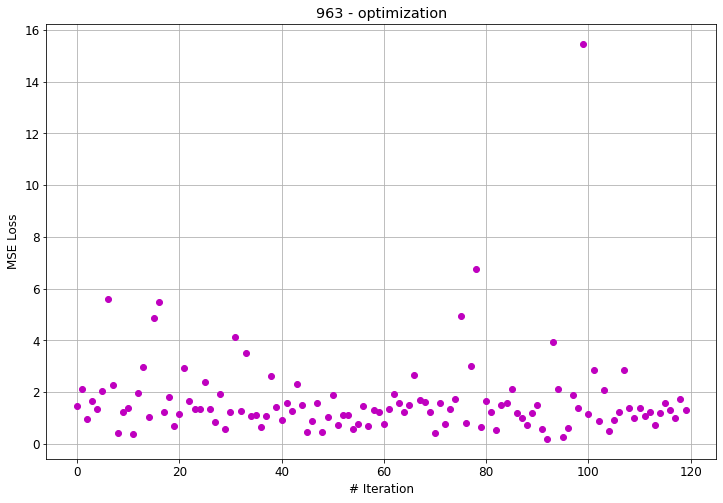

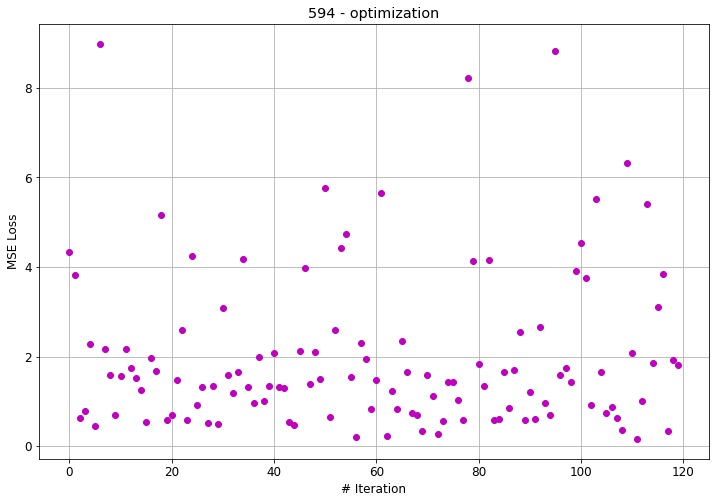

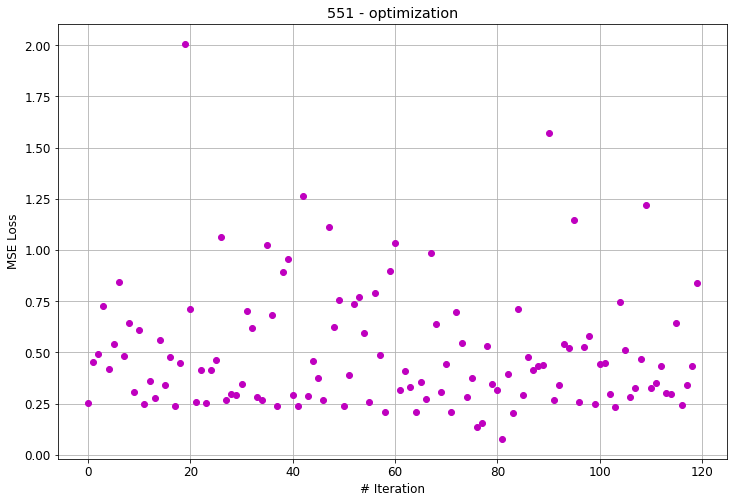

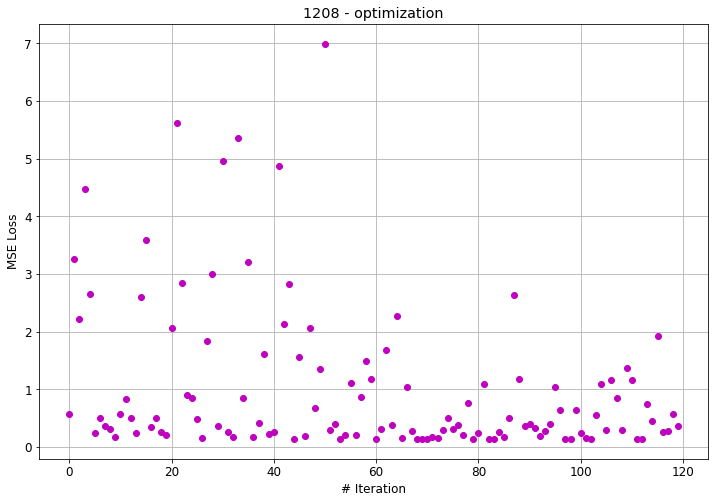

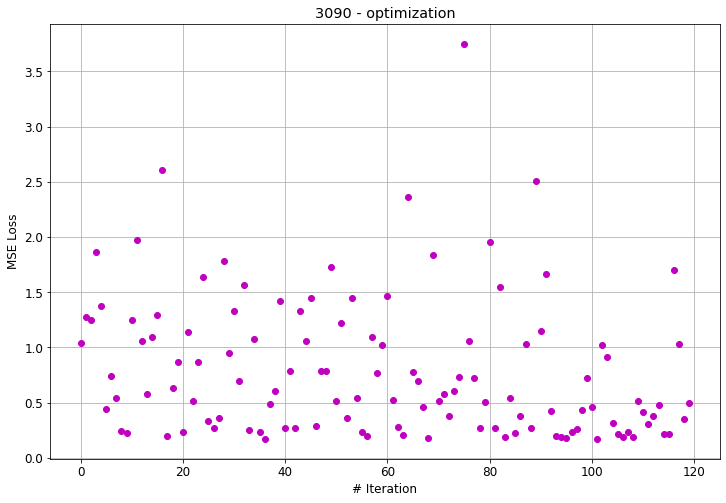

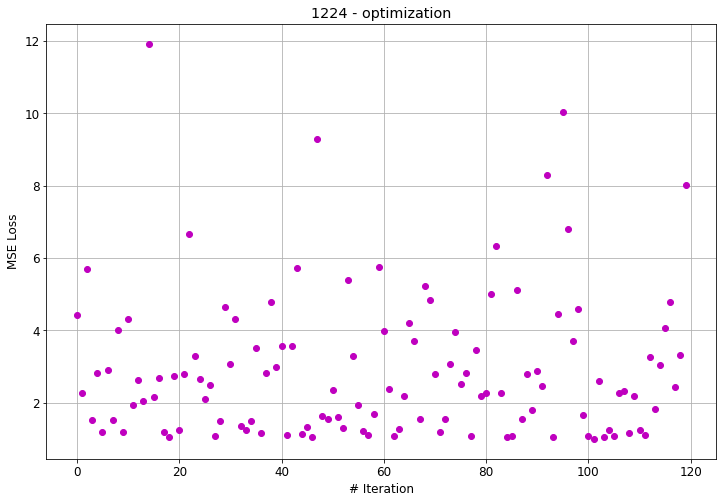

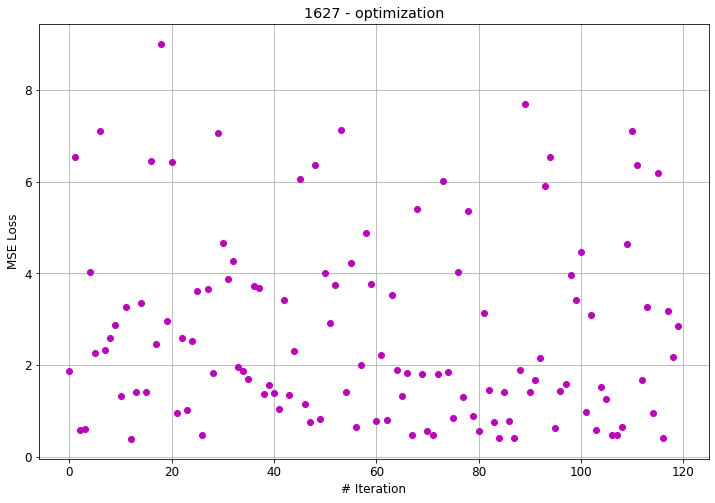

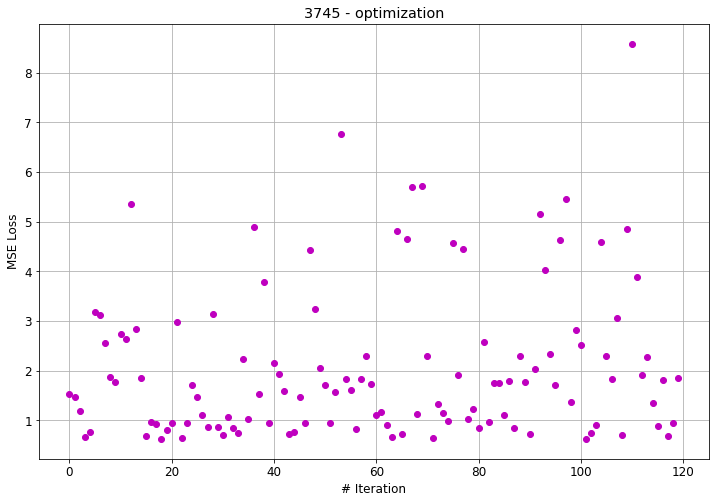

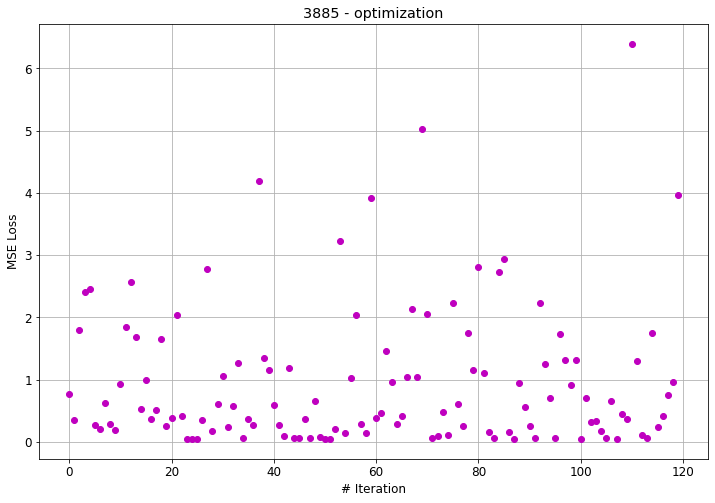

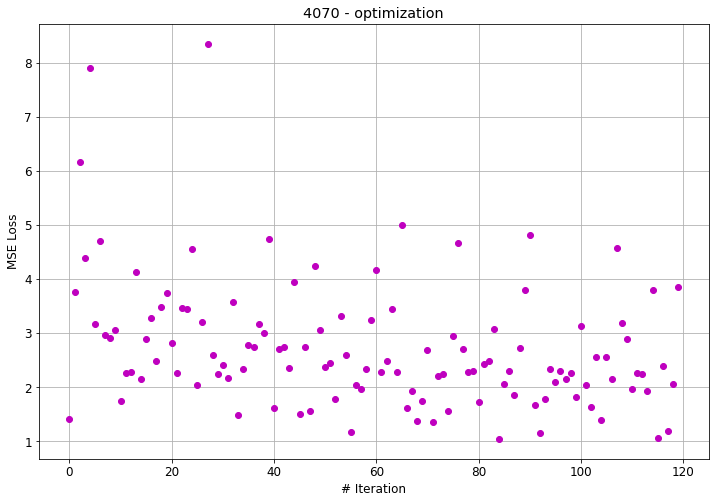

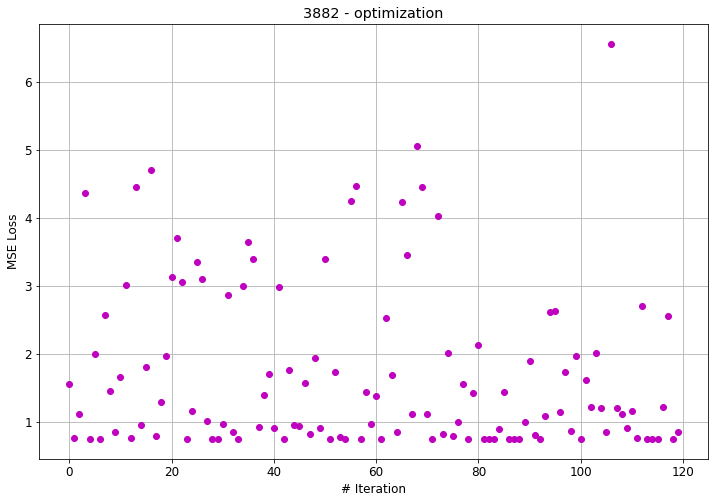

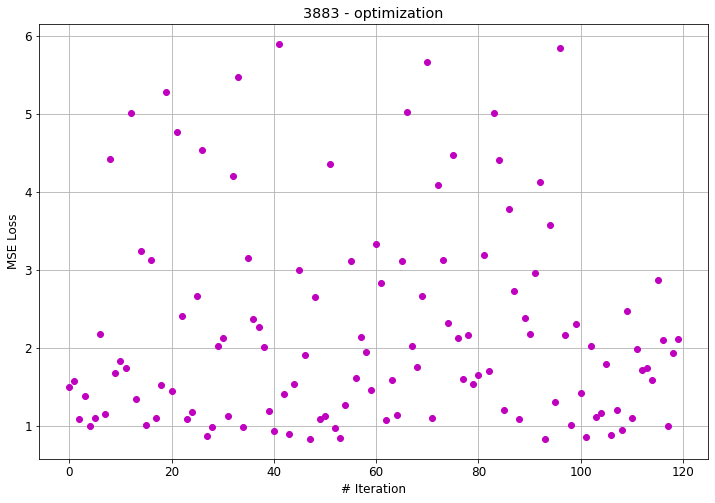

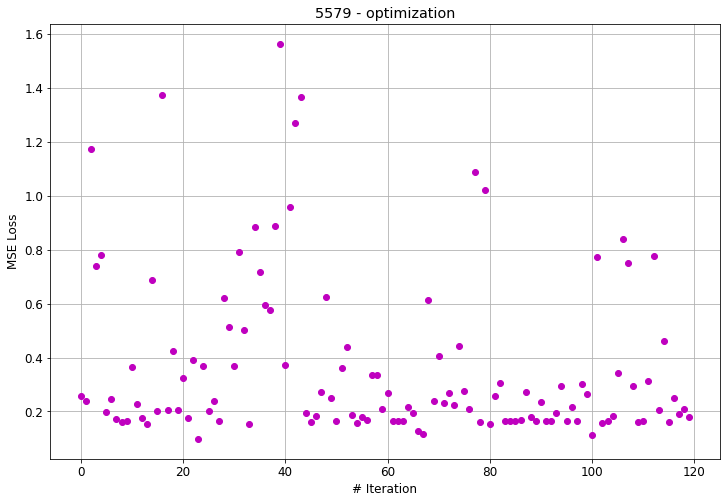

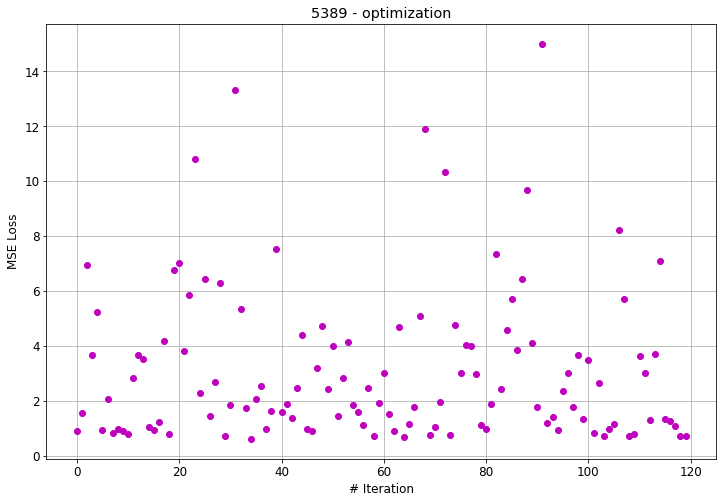

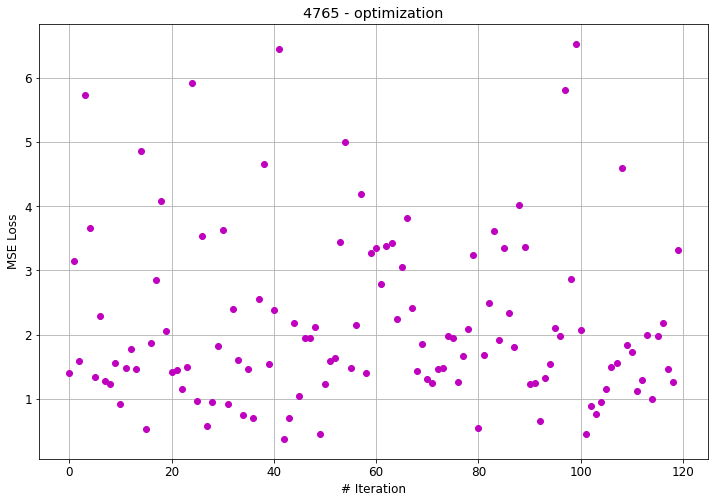

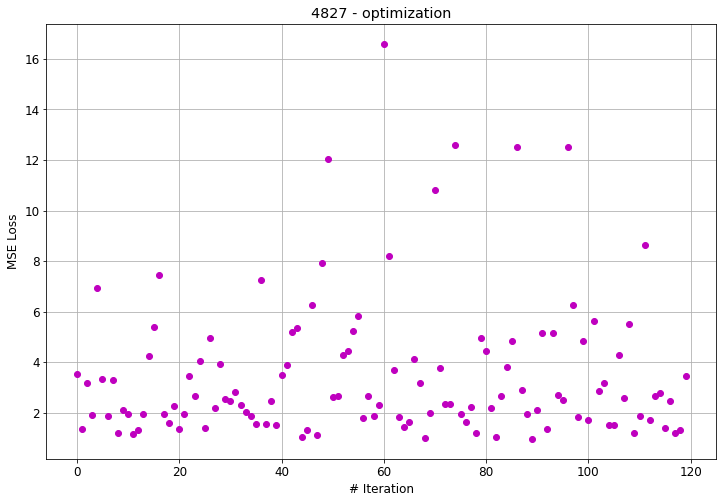

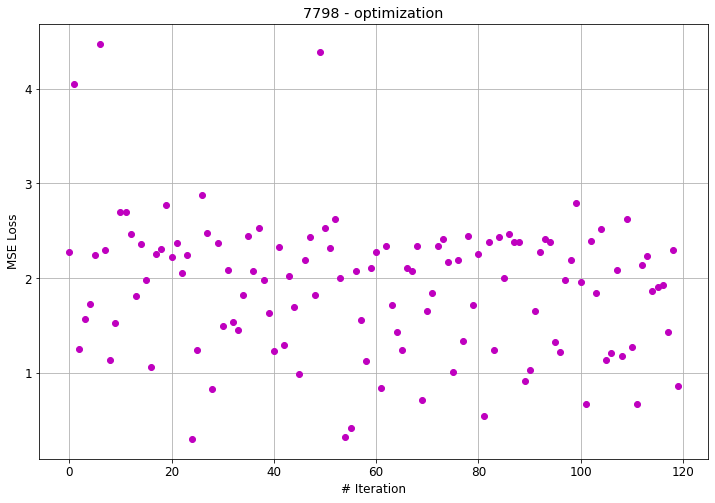

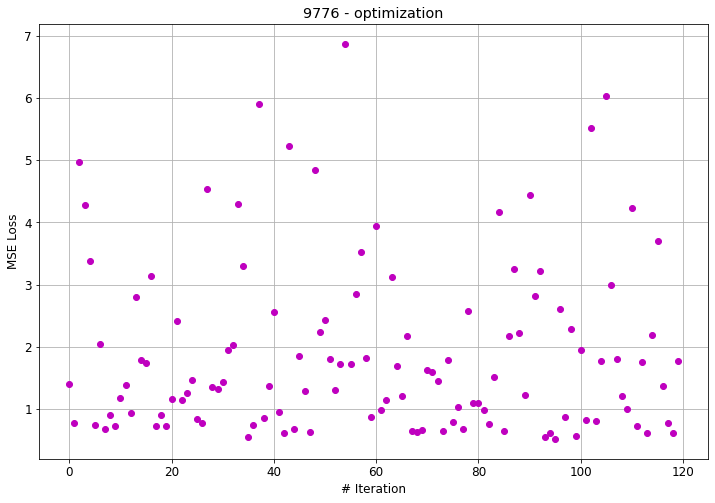

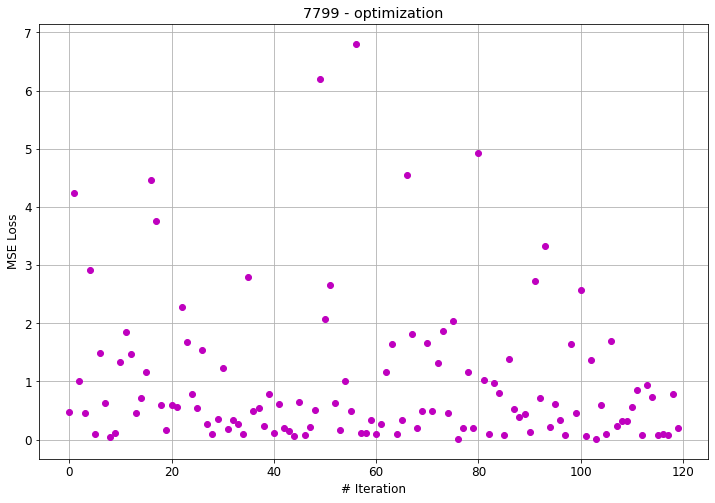

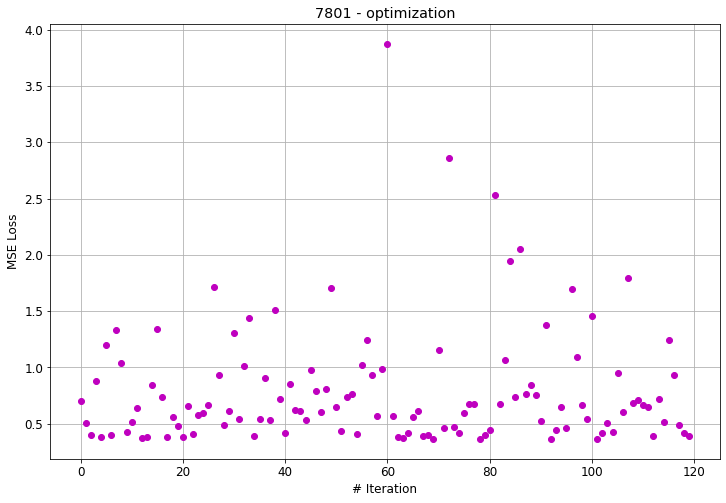

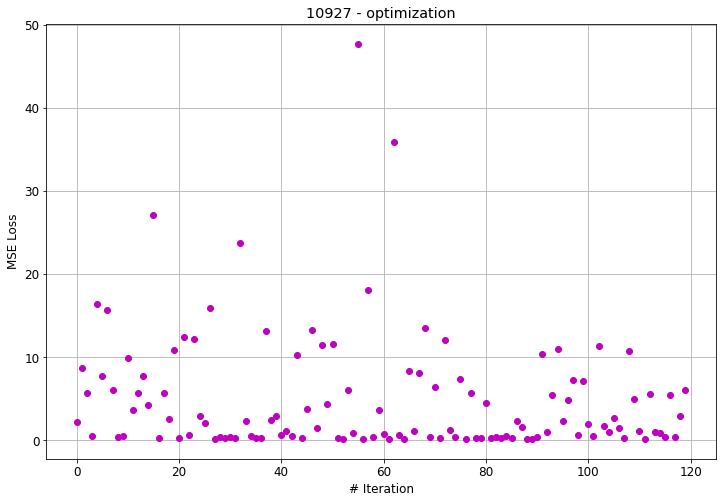

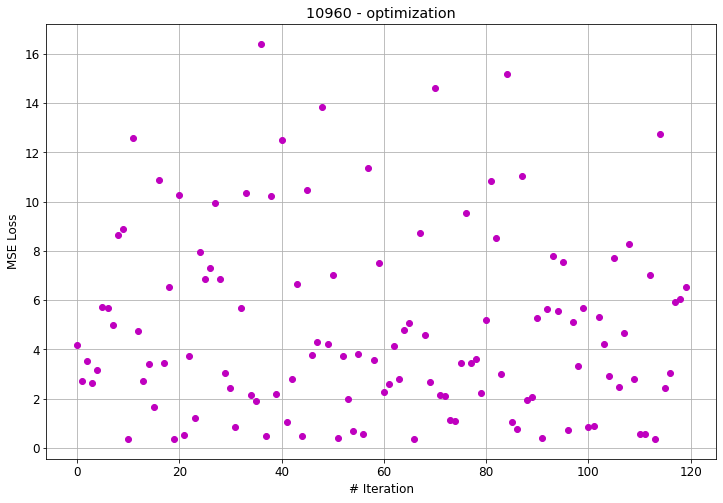

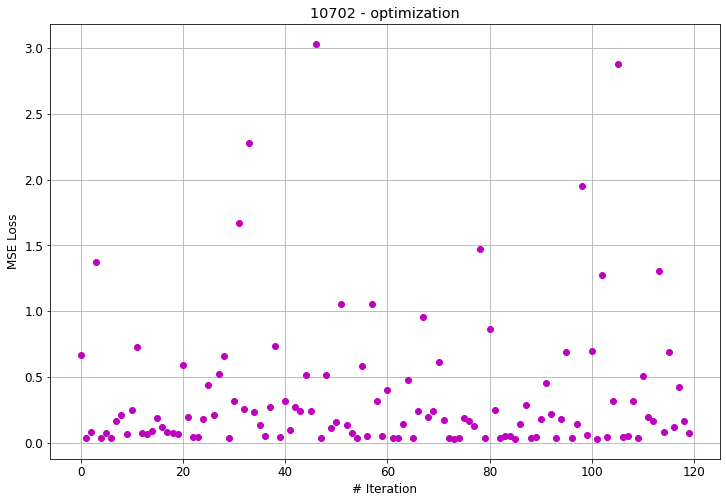

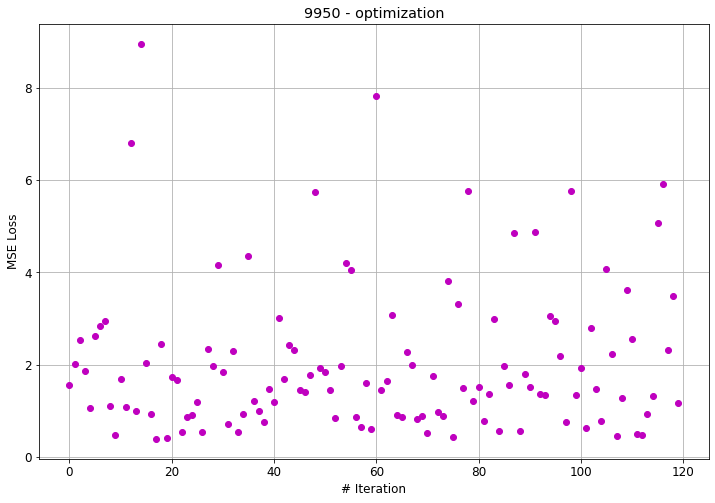

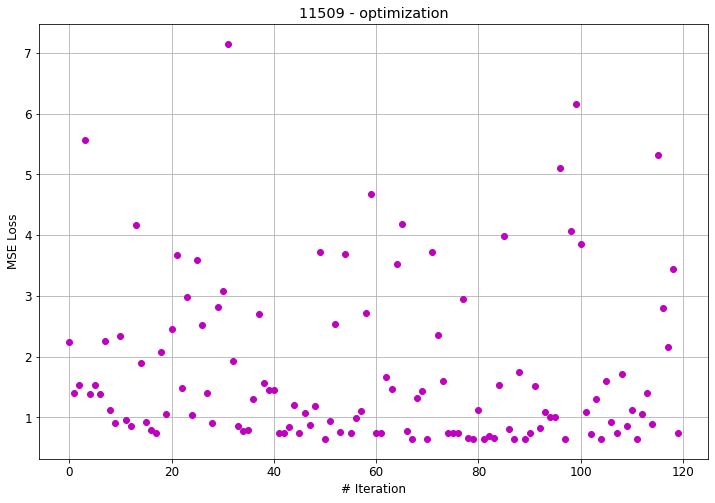

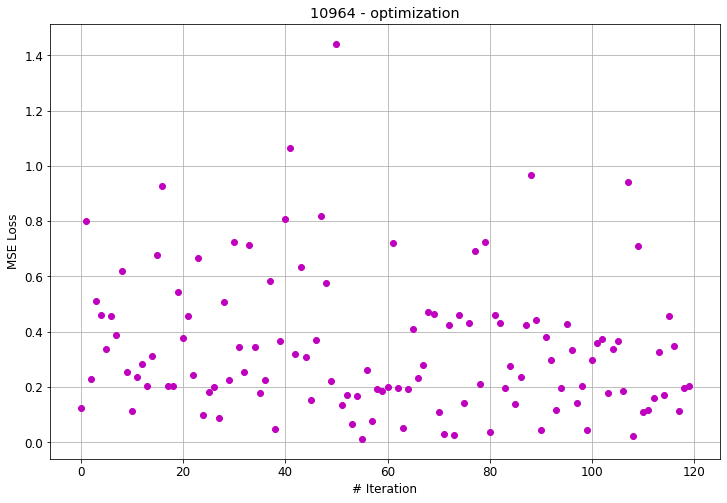

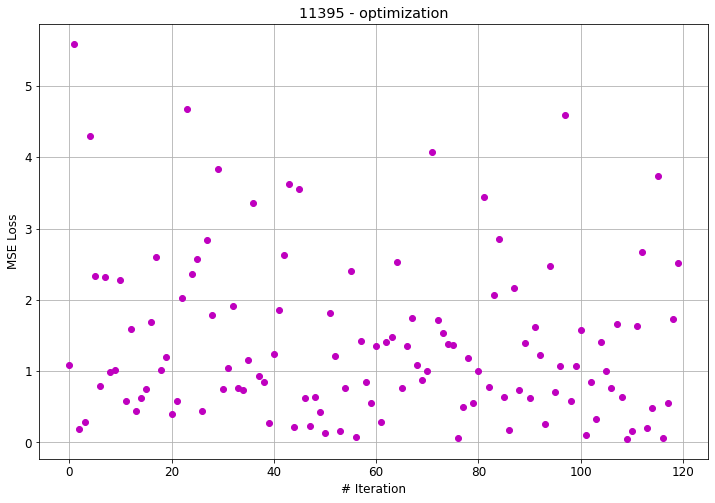

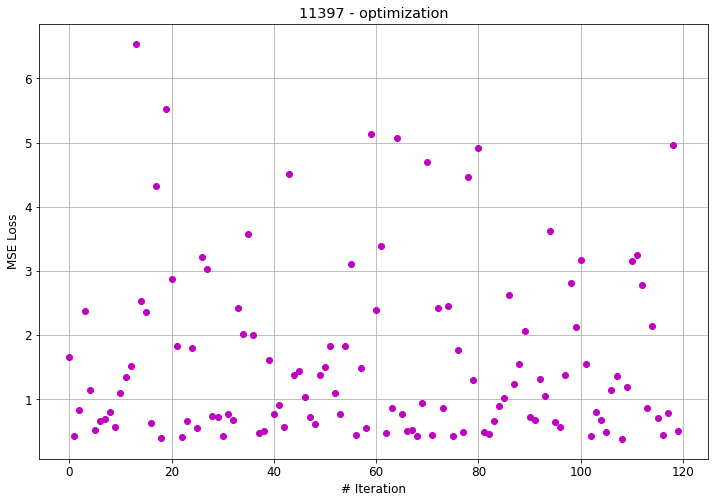

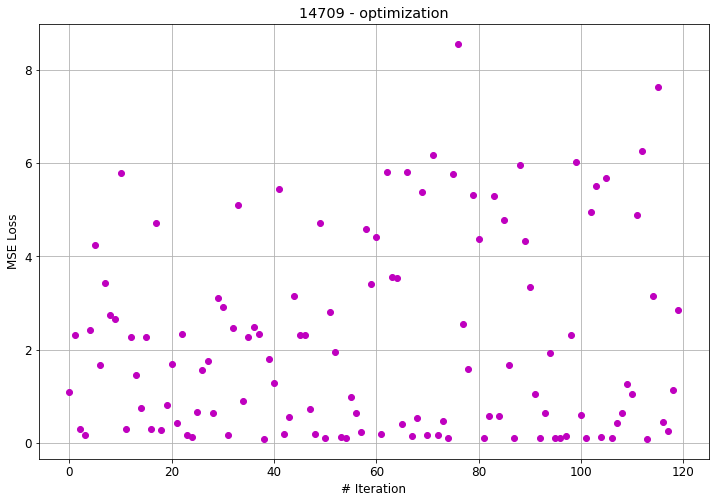

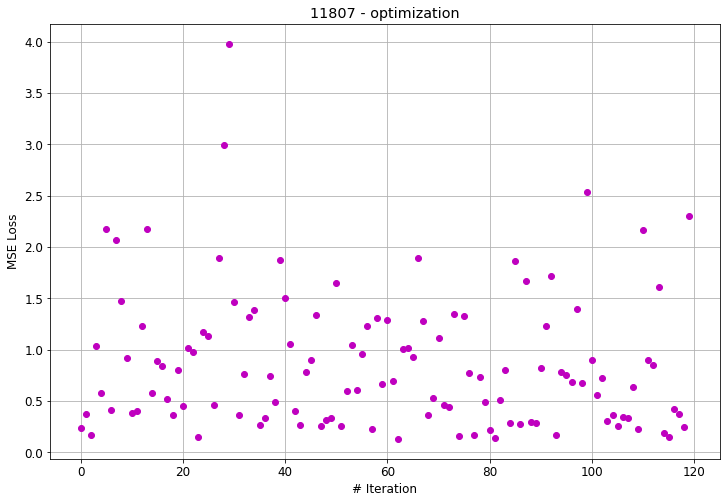

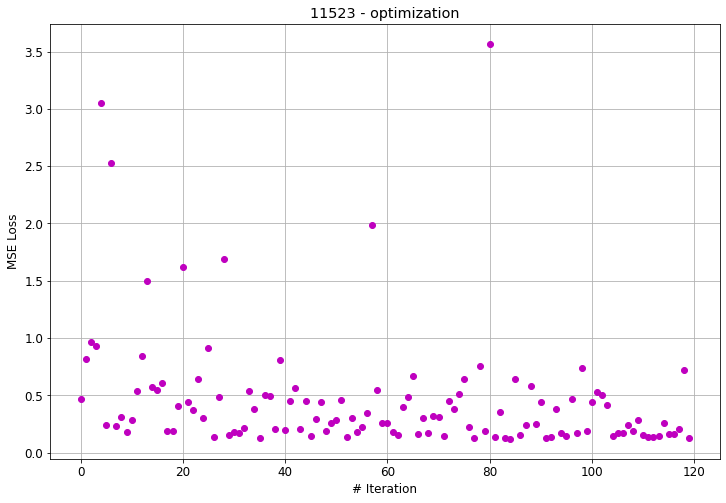

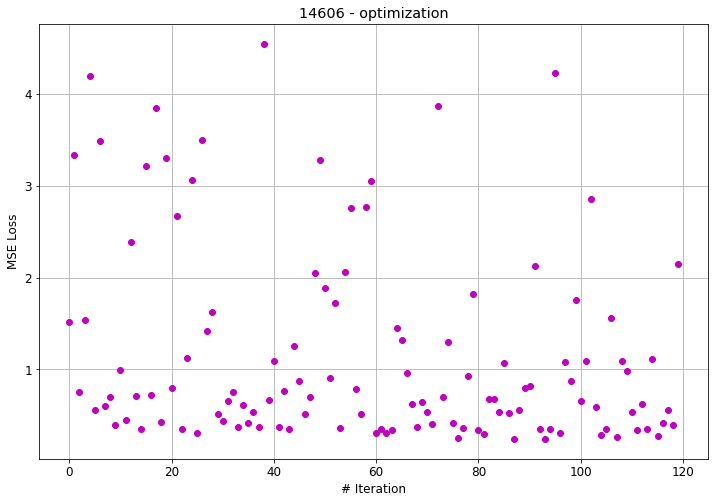

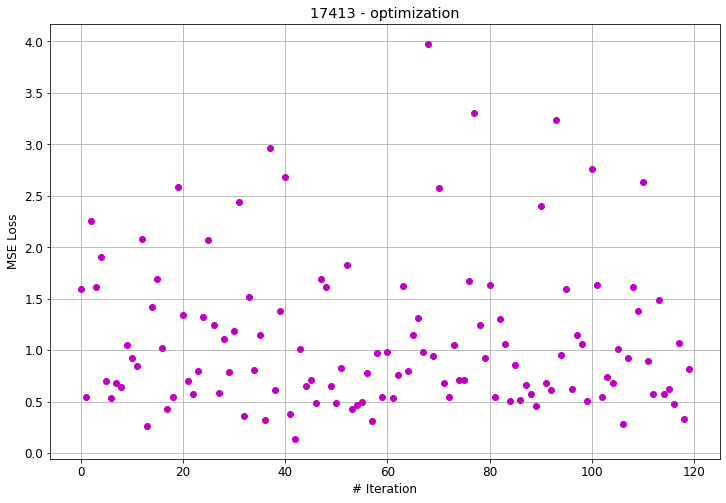

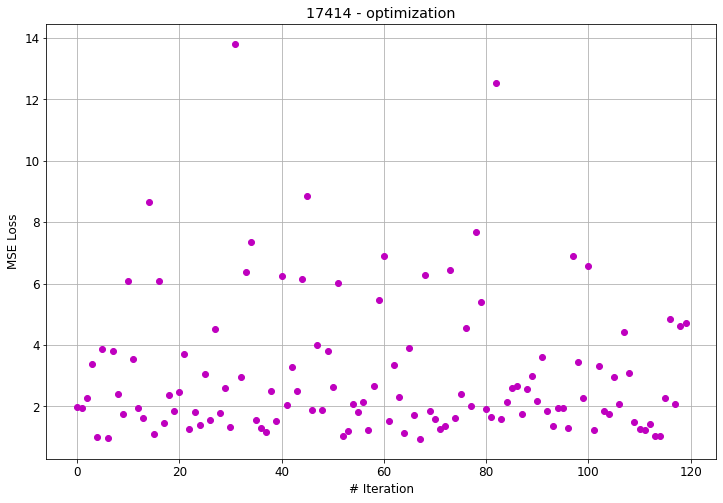

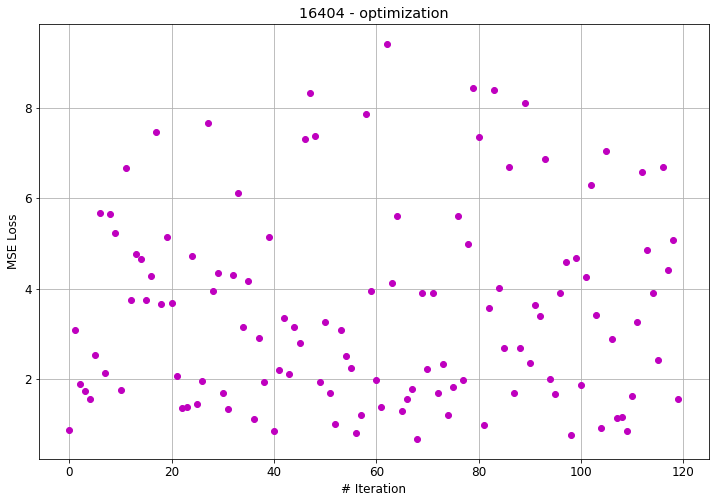

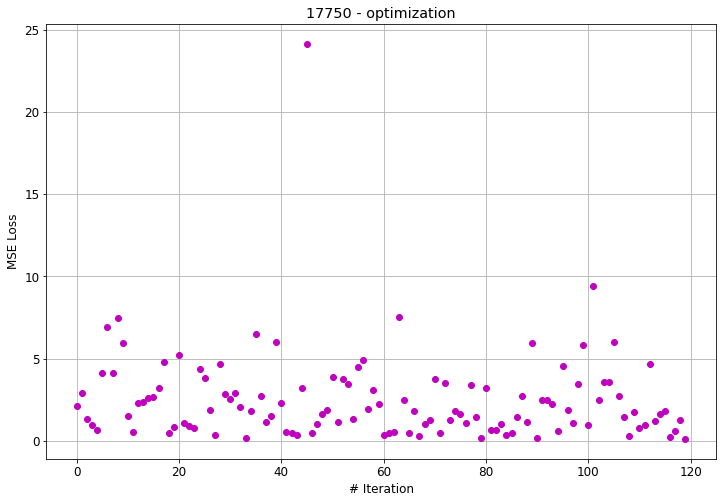

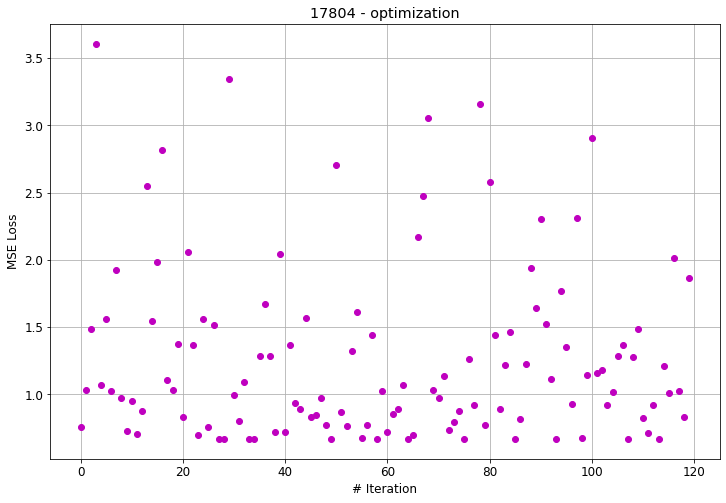

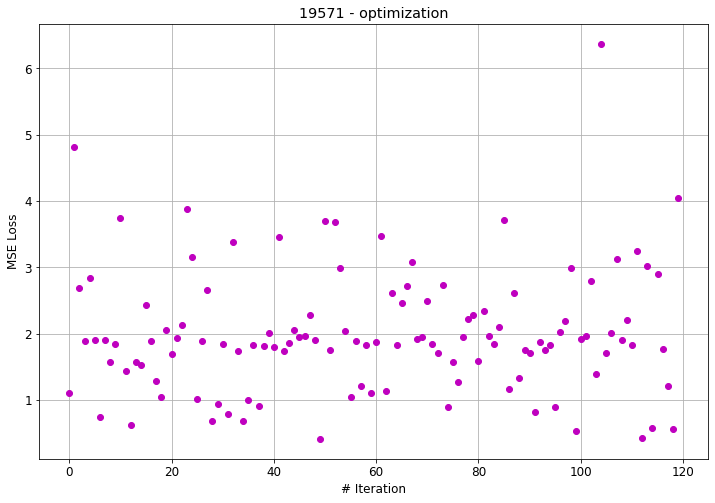

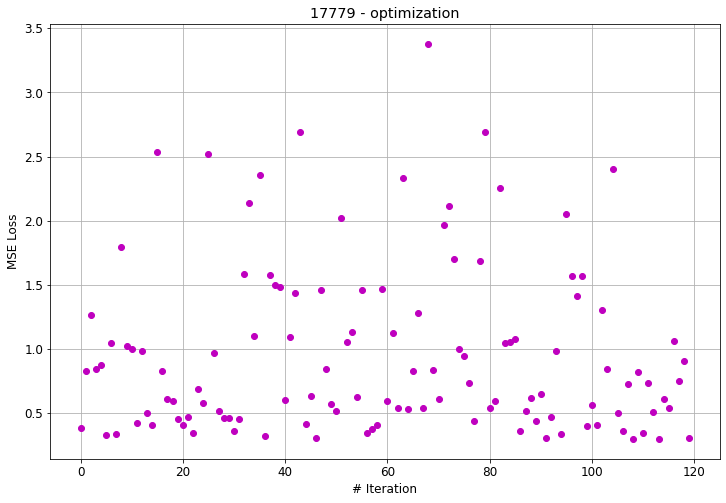

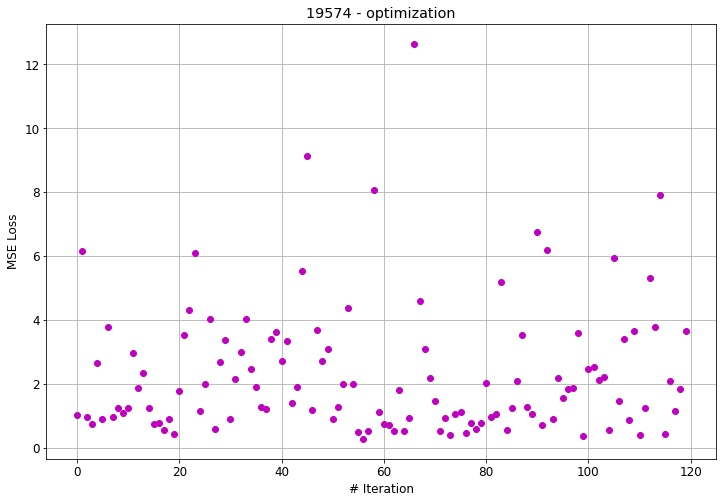

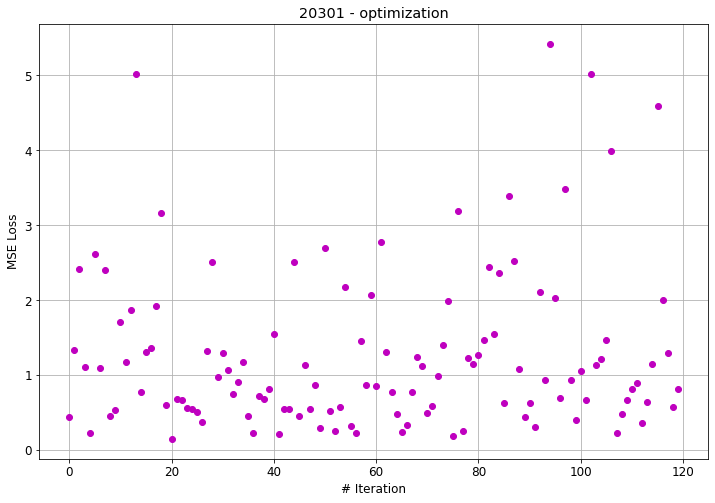

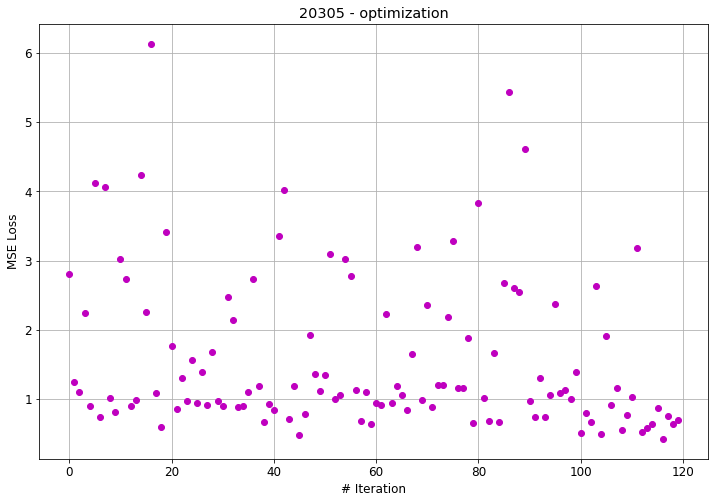

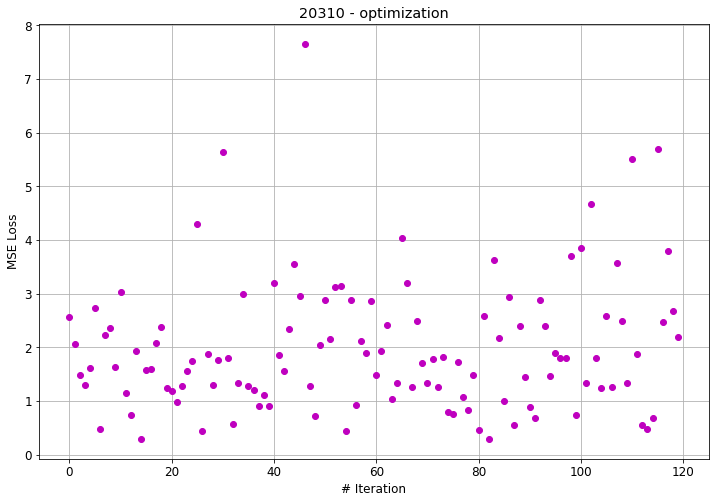

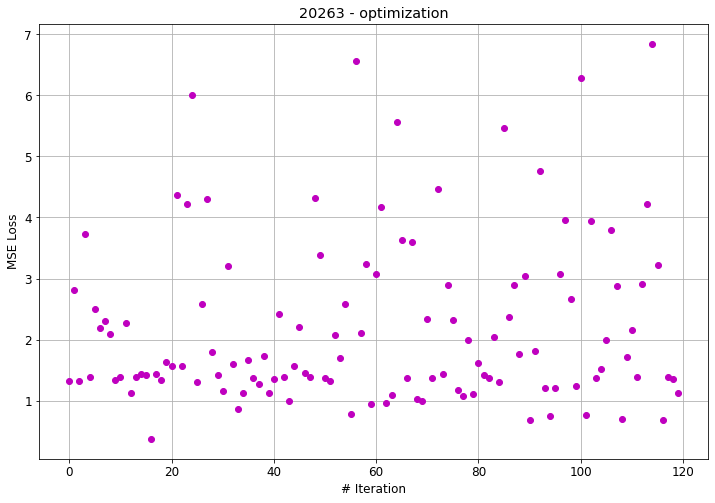

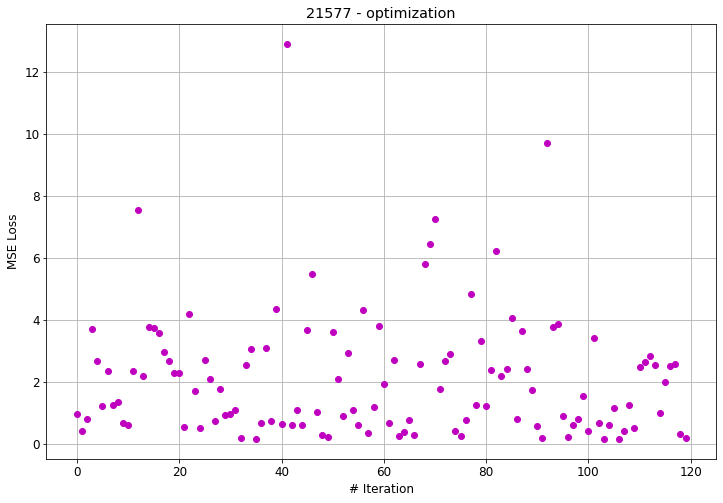

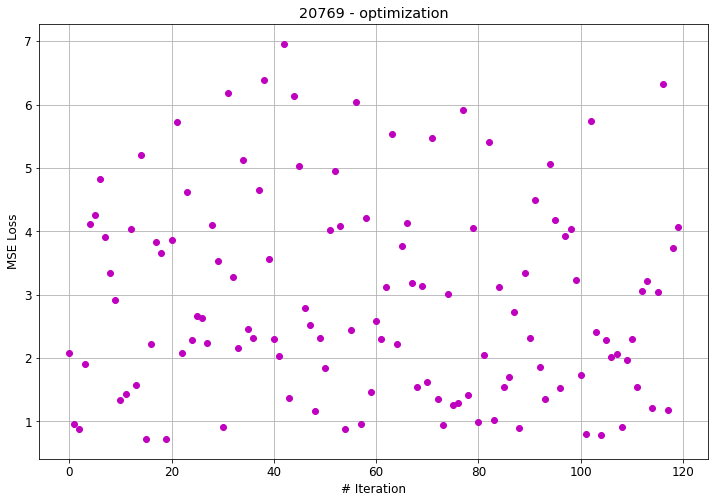

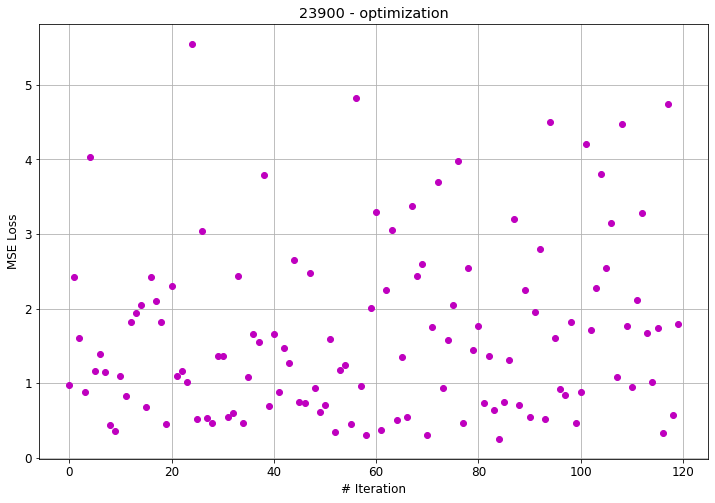

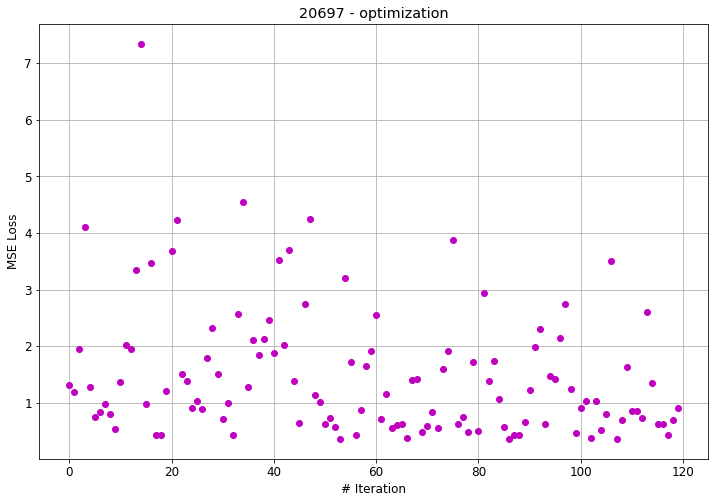

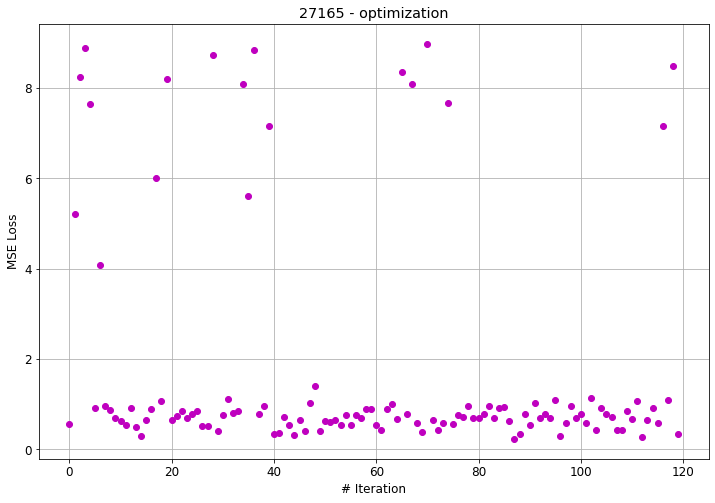

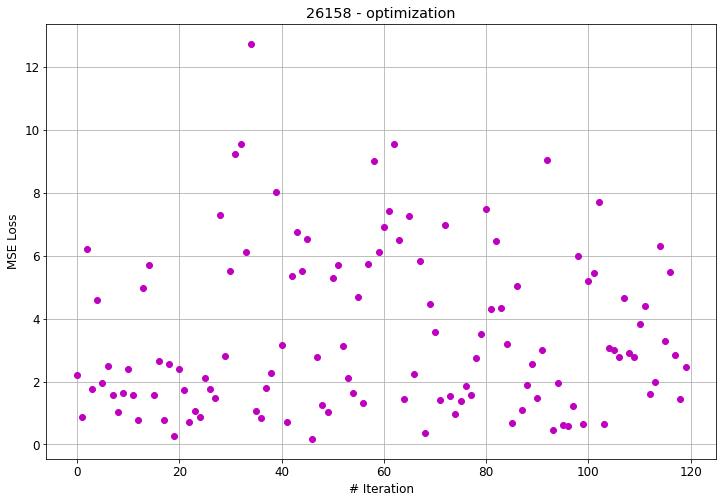

In [15]:
optimizer.print_optimizer_results()

In [16]:
optimizer.results.head()

,idArticulo,hyper,r2_test,mse_test,model
0,963.0,"{'n_lags': 4, 'random_state': 1944, 'optimizer...",-0.006393,1.027604,DL
1,594.0,"{'n_lags': 6, 'random_state': 1474, 'optimizer...",-0.436021,3.279004,DL
2,551.0,"{'n_lags': 6, 'random_state': 2073, 'optimizer...",-3.941967,0.421291,DL
3,1208.0,"{'n_lags': 7, 'random_state': 2340, 'optimizer...",-0.004282,0.032514,DL
4,3090.0,"{'n_lags': 2, 'random_state': 1654, 'optimizer...",-0.278165,1.565380,DL
